In [1]:
from Gridworld import Gridworld
import torch
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from itertools import count

In [2]:
class GridQNet(torch.nn.Module):
    def __init__(self, size, start_epsilon = 1):
        super().__init__()
        self.size = size
        n_input = size * size * 4
        self.l1 = torch.nn.Linear(n_input, 150)
        self.l2 = torch.nn.Linear(150, 100)
        self.l3 = torch.nn.Linear(100, 4)
        self.epsilon = start_epsilon
        
    def forward(self, x):
        a1 = F.leaky_relu(self.l1(x))
        a2 = F.leaky_relu(self.l2(a1))
        qvals = self.l3(a2)
        
        if np.random.rand() > self.epsilon:
            action = torch.argmax(qvals)
        else:
            action = np.random.randint(4)
        return action, qvals
    
    def decrement_epsilon(self):
        self.epsilon = max(self.epsilon * 0.9, 0.1)
    

In [52]:
loss_fn = torch.nn.MSELoss()

lr = 1e-03
gamma = 0.9

action_map = ['u', 'd', 'l', 'r']

def get_game_state(game, size):
    state = game.board.render_np().reshape(1, -1) + np.random.uniform(-0.01, 0.01, size = size * size * 4)
    return torch.from_numpy(state).float()

def test_model(model, mode = 'player', display = True):
    size = model.size
    test_game = Gridworld(mode = mode, size = size)
    for i in count():
        state = get_game_state(test_game, size)
        reward = test_game.reward()
        if reward != -1:
            s = 'win' if reward == 10 else 'loss'
            print(f'Fin: {s}, {i}')
            print(test_game.display())
            break
        action, _ = model(state)
        if display:
            print(f'Action: {action_map[action]}, {i}')
            print(test_game.display())
        test_game.makeMove(action_map[action])        

def benchmark_model(model, iters = 1000, mode = 'random', size = 4):
    l = []
    size = model.size
    for i in range(iters):
        test_game = Gridworld(mode = mode, size = size)
        for j in range(50):
            state = get_game_state(test_game, size)
            reward = test_game.reward()
            if reward != -1:
                l.append(float(reward == 10))
                break
            action, _ = model(state)
            test_game.makeMove(action_map[action]) 
        else:
            l.append(0.)
    return sum(l)/iters

In [57]:
def basic_train(model, loss_fn, iterations, lr = 1e-03, gamma = 0.9, mode = 'static'):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losses = []
    for i in tqdm(range(iterations)):
        game = Gridworld(size = size, mode = mode)
        state1 = get_game_state(game, size)
        while True:
            action, qvals = model(state1)
            game.makeMove(action_map[action])
            state2 = get_game_state(game, size)
            reward = game.reward()
            with torch.no_grad():
                action2, qvals2 = model(state2)
            max_q = torch.max(qvals2)
            if reward == -1:
                Y = reward + gamma * max_q
            else:
                Y = reward
            tar = torch.Tensor([Y]).squeeze()
            inp = qvals.squeeze()[action]
            loss = loss_fn(inp, tar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            state1 = state2
            losses.append(loss.item())
            if reward != -1:
                break
        model.decrement_epsilon()
    return losses

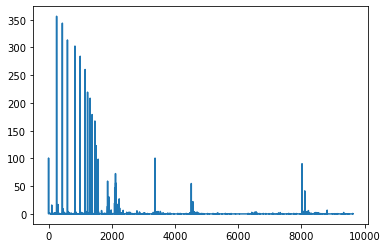

In [58]:
iterations = 1000
model0 = GridQNet(size)
size = 4
losses = basic_train(model0, loss_fn, iterations, lr, gamma)
plt.plot(losses)
plt.show()

In [10]:
from collections import deque
import random

def experience_replay_train(
    model,
    loss_fn,
    iterations,
    lr = 1e-03,
    gamma = 0.9,
    mode = 'random',
    mem_size = 1000,
    batch_size = 200,
    max_game_iter = 50):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losses = []
    memory = deque(maxlen = mem_size)
    for i in tqdm(range(iterations)):
        game = Gridworld(size = size, mode = mode)
        state1 = get_game_state(game, size)
        for _ in range(max_game_iter):
            action, qvals = model(state1)
            game.makeMove(action_map[action])
            state2 = get_game_state(game, size)
            reward = game.reward()
            with torch.no_grad():
                action2, qvals2 = model(state2)
            max_q = torch.max(qvals2)
            
            done = reward != -1
            
            memory.append([action, state1, state2, reward, done])
            state1 = state2
            if len(memory) > batch_size:
                minibatch = random.sample(memory, batch_size)
                s1b = torch.cat([s1 for (a, s1, s2, r, d) in minibatch])
                s2b = torch.cat([s2 for (a, s1, s2, r, d) in minibatch])
                rb = torch.tensor([r for (a, s1, s2, r, d) in minibatch], dtype = torch.float32)
                ab = torch.tensor([a for (a, s1, s2, r, d) in minibatch], dtype = torch.long).reshape(-1, 1)
                db = torch.tensor([d for (a, s1, s2, r, d) in minibatch], dtype = torch.int)
                
                _, q1 = model(s1b)
                with torch.no_grad():
                    action2, qvals2 = model(s2b)
                tar = rb + gamma * torch.max(qvals2, dim = 1).values * (1 - db)
                inp = q1.gather(dim = 1, index = ab).squeeze()
                loss = loss_fn(inp, tar)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            if reward != -1:
                break
        model.decrement_epsilon()
    return losses

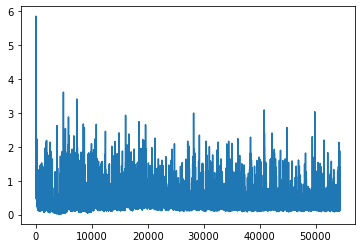

CPU times: user 46min 8s, sys: 30min 47s, total: 1h 16min 56s
Wall time: 7min 27s


In [11]:
%%time
iterations = 5000
size = 4
model1 = GridQNet(size)

losses = experience_replay_train(model1, loss_fn, iterations, lr, gamma)
plt.plot(losses)
plt.show()

In [59]:
import copy

def target_network_train(
    model,
    loss_fn,
    iterations,
    lr = 1e-03,
    gamma = 0.9,
    mode = 'random',
    mem_size = 1000,
    batch_size = 200,
    max_game_iter = 50,
    sync_freq = 500):
    
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    losses = []
    memory = deque(maxlen = mem_size)
    
    target_model = copy.deepcopy(model)
    target_model.load_state_dict(model.state_dict())
    
    j = 0
    
    for i in tqdm(range(iterations)):
        game = Gridworld(size = size, mode = mode)
        state1 = get_game_state(game, size)
        for _ in range(max_game_iter):
            j += 1
            action, qvals = model(state1)
            game.makeMove(action_map[action])
            state2 = get_game_state(game, size)
            reward = game.reward()
            with torch.no_grad():
                action2, qvals2 = model(state2)
            max_q = torch.max(qvals2)
            
            done = reward != -1
            
            memory.append([action, state1, state2, reward, done])
            state1 = state2
            if len(memory) > batch_size:
                minibatch = random.sample(memory, batch_size)
                s1b = torch.cat([s1 for (a, s1, s2, r, d) in minibatch])
                s2b = torch.cat([s2 for (a, s1, s2, r, d) in minibatch])
                rb = torch.tensor([r for (a, s1, s2, r, d) in minibatch], dtype = torch.float32)
                ab = torch.tensor([a for (a, s1, s2, r, d) in minibatch], dtype = torch.long).reshape(-1, 1)
                db = torch.tensor([d for (a, s1, s2, r, d) in minibatch], dtype = torch.int)
                
                _, q1 = model(s1b)
                with torch.no_grad():
                    action2, qvals2 = target_model(s2b)
                
                tar = rb + gamma * torch.max(qvals2, dim = 1).values * (1 - db)
                inp = q1.gather(dim = 1, index = ab).squeeze()
                loss = loss_fn(inp, tar)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
                
                if j % sync_freq == 0:
                    target_model.load_state_dict(model.state_dict())
            if reward != -1:
                break
        model.decrement_epsilon()
    return losses

In [61]:
%%time
iterations = 5000
size = 4

sync_freqs = [50, 100, 300, 500]
models = []
all_losses = []
for sync_freq in sync_freqs:
    model2 = GridQNet(size)
    losses = target_network_train(model2, loss_fn, iterations, lr, gamma, sync_freq = sync_freq)
    models.append(model2)
    all_losses.append(losses)


CPU times: user 3h 5min 4s, sys: 2h 2min 13s, total: 5h 7min 18s
Wall time: 29min 28s


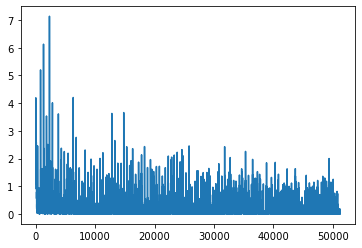

In [67]:
plt.plot(all_losses[3])

In [66]:
for model in models:
    print(benchmark_model(model))

0.878
0.853
0.923
0.93


In [55]:
old_models = models
old_losses = all_losses